<a href="https://colab.research.google.com/github/faranbutt/GAN-Learning/blob/main/VAE_Celeb_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input,InputLayer, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import (layers, models, callbacks, utils, metrics, optimizers,losses)
import tensorflow.keras.backend as K
from tensorflow.keras.utils import img_to_array, load_img
from PIL import Image

In [2]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeba-dataset


In [3]:
!ls $path

img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


In [4]:
!ls /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba | head -n 3

000001.jpg
000002.jpg
000003.jpg


In [5]:
image_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

In [6]:
images_list = [os.path.join(image_dir,f_name) for f_name in sorted(os.listdir(image_dir))]
images_list[:2]

['/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg',
 '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000002.jpg']

In [7]:
def display_images(batch,num):
  plt.figure(figsize = (5,5))
  for i in range(num):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i].numpy())
    plt.axis('off')
  plt.show()



In [97]:
BATCH_SIZE=128
IMAGE_SIZE=32
LEARNING_RATE=0.0005
EPOCHS=2
CHANNELS=3
BETA=2000
LOAD_MODEL=False
NUM_FEATURES = 128
Z_DIM = 200

In [15]:
train_data = utils.image_dataset_from_directory(
    image_dir,
    labels = None,
    color_mode='rgb',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed = 42,
    interpolation = 'bilinear'
)

Found 202599 files.


In [17]:
def preprocess(img):
  img = tf.cast(img,'float32') / 255.0
  return img

In [18]:
train = train_data.map(lambda x: preprocess(x))

<_MapDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

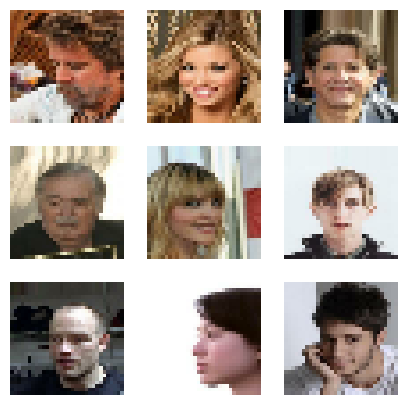

In [19]:
for batch in train.take(1):
  display_images(batch,9)

In [25]:
class Sampling(layers.Layer):
  def call(self,inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch,dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [43]:
encoder_base = Sequential([
    InputLayer(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),name='encoder_input'),

    Conv2D(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),


    Conv2D(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),


    Conv2D(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),

    Conv2D(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),


    Flatten()

],name = "Encoder_Base")

encoder_base.summary()

Model: "Encoder_Base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,384 (1.71 MB)

 Trainable params: 447,360 (1.71 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [47]:
encoder_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = encoder_base(encoder_input)

z_mean = Dense(Z_DIM,name = 'z_mean')(x)
z_log_var = Dense(Z_DIM,name='z_var')(x)


z = Sampling()([z_mean,z_log_var])
encoder = Model(encoder_input,[z_mean,z_log_var,z],name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Base        │ (None, 512)       │    448,384 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    102,600 │ Encoder_Base[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_var (Dense)       │ (None, 200)       │    102,600 │ Encoder_Base[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_var[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 653,584 (2.49 MB)

 Trainable params: 652,560 (2.49 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [48]:
shape_before_flattening = (2, 2, 128)

In [60]:
decoder = Sequential([
    Input(shape = (Z_DIM,),name='decoder_input'),
    Dense(np.prod(shape_before_flattening)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape(shape_before_flattening),

    Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),


    Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),


    Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(CHANNELS,kernel_size=3,strides=1,activation = 'sigmoid',padding='same')


],name = 'Decoder')
decoder.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 4, 4, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 32, 32, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,803 (2.67 MB)

 Trainable params: 698,755 (2.67 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [89]:
class VAE(Model):
  def __init__(self,encoder,decoder,**kwargs):
    super(VAE,self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.total_loss_tracker = metrics.Mean(name='total_loss')
    self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
    self.kl_loss_tracker = metrics.Mean(name='kl_loss')


  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker
    ]


  def call(self,inputs):

    z_mean,z_log_var,z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean,z_log_var, reconstruction


  def train_step(self,data):
    with tf.GradientTape() as tape:
      z_mean,z_log_var, reconstruction = self(data,training=True)
      mse = losses.MeanSquaredError(reduction='none')
      mse_loss = mse(data,  reconstruction)
      reconstruction_loss = tf.reduce_mean(BETA * mse_loss)
      kl_loss = tf.reduce_mean(
          tf.reduce_sum(
              -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
              axis = 1
          )
      )

      total_loss = reconstruction_loss + kl_loss

      grads = tape.gradient(total_loss, self.trainable_weights)

      self.optimizer.apply_gradients(zip(grads,self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      return {
          "loss" : self.total_loss_tracker.result(),
          "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
          "kl_loss" :self.kl_loss_tracker.result()
      }

      def test_step(self,data):
        if isinstance(data,tuple):
          data = data[0]


        z_mean,z_log_var, reconstruction = self(data,training=True)
        mse = losses.MeanSquaredError(reduction='none')
        mse_loss = mse(data,  reconstruction)
        econstruction_loss = tf.reduce_mean(BETA * mse_loss)
        kl_loss = tf.reduce_mean(
          tf.reduce_sum(
              -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
              axis = 1
              )
          )
        total_loss = reconstruction_loss + kl_loss
        return {
          "loss" : self.total_loss_tracker.result(),
          "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
          "kl_loss" :self.kl_loss_tracker.result()
        }


In [90]:
vae = VAE(encoder,decoder)

In [91]:
vae.summary()

Model: "vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 200), (None,   │       653,584 │
│                                 │ 200), (None, 200))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 32, 32, 3)      │       700,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,387 (5.17 MB)

 Trainable params: 1,351,315 (5.15 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [92]:
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [99]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = './checkpoint/model_checkpoint.keras',
    mode='min',
    save_weights_only=False,
    save_best_only=True,
    save_freq='epoch',
    monitor='loss',
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [100]:
class ImageGenerator(callbacks.Callback):
  def __init__(self,num_img,laten_dim,grid_size=None,output_dir = "./"):
    self.num_img = num_img
    self.laten_dim = laten_dim
    self.grid_size = grid_size or int(np.ceil(np.sqrt(num_img)))
    self.out_dir = output_dir

  def on_epoch_end(self,epoch,logs = None):
    random_latent_vectors = tf.random.normal(
        shape = (self.num_img,self.laten_dim)
    )

    generated_images  = self.model.decoder(random_latent_vectors)

    generated_images = tf.clip_by_value(generated_images * 255, 0, 255)
    generated_images = tf.cast(generated_images, tf.uint8).numpy()

    h,w,c = generated_images.shape[1:]

    grid_img = Image.new("RGB",(w * self.grid_size, h * self.grid_size))

    for idx, img_arr in enumerate(generated_images):
      img = Image.fromarray(img_arr)
      row = idx // self.grid_size
      col = idx % self.grid_size
      grid_img.paste(img, (col*w,row*h))


        # 5. Save grid image
    grid_img.save(f"{self.out_dir}/generated_grid_epoch_{epoch:03d}.png")
    print(f"Saved generated image grid for epoch {epoch}")


In [101]:
if LOAD_MODEL:
  vae.load_weights("./models/vae.grid")
  tmp = vae.predict(train.take(1))

In [102]:
vae.fit(
    train,
    epochs = EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10,laten_dim=Z_DIM)
    ]
)

Epoch 1/2
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl_loss: 16.5529 - loss: 65.3415 - reconstruction_loss: 48.7886Saved generated image grid for epoch 0
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2960s 2s/step - kl_loss: 16.5530 - loss: 65.3413 - reconstruction_loss: 48.7883
Epoch 2/2
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl_loss: 16.8933 - loss: 64.2124 - reconstruction_loss: 47.3190Saved generated image grid for epoch 1
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2937s 2s/step - kl_loss: 16.8934 - loss: 64.2122 - reconstruction_loss: 47.3188


In [103]:
vae.save('/content/models/vae.keras')
encoder.save('/content/models/encoder.keras')
decoder.save('/content/models/decoder.keras')

In [108]:
import imageio
import glob
from IPython.display import Image

In [107]:
image_files = sorted(glob.glob('generated_grid_epoch_*.png'))
images = [imageio.imread(img) for img in image_files]
imageio.mimsave("vae_training_progress.gif", images, fps=2)

/tmp/ipython-input-1403069633.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(img) for img in image_files]


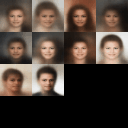

In [114]:
display(Image(filename='/content/vae_training_progress.gif',width=300))

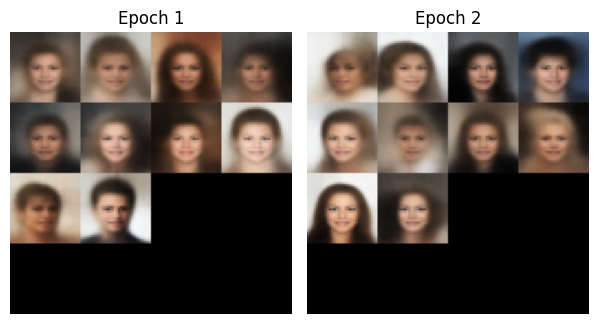

In [116]:
import matplotlib.image as mpimg
plt.figure(figsize=(15, 5))
for i, file in enumerate(image_files):
    img = mpimg.imread(file)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Epoch {i+1}")
plt.tight_layout()
plt.show()

In [123]:
partition_df = pd.read_csv(os.path.join(path,'list_eval_partition.csv'))
partition_df.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [124]:
test_image = partition_df[partition_df['partition'] == 2]
test_image.head()

,image_id,partition
182637,182638.jpg,2
182638,182639.jpg,2
182639,182640.jpg,2
182640,182641.jpg,2
182641,182642.jpg,2


In [125]:
print(f'Number of test images are {len(test_image)}')

Number of test images are 19962


In [130]:
def preprocess_test_images(filepath):
  img = load_img(filepath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  img = img_to_array(img)
  img = img / 255.0
  return img

test_image_paths = [
    os.path.join("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba", fname)
    for fname in test_image["image_id"].values
]

test_images_np = np.array([
    preprocess_test_images(img_path) for img_path in test_image_paths[:100]
])

In [132]:
z_mean, z_log_var, reconstructed = vae.predict(test_images_np)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step


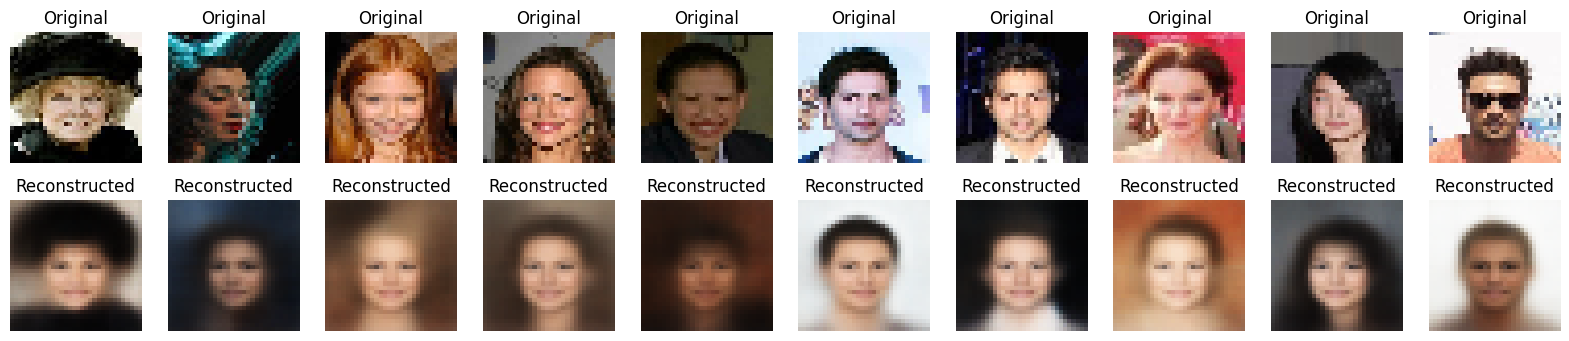

In [133]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images_np[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()